In [1]:
import sys

import sklearn
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
train = pd.read_csv('train.csv', index_col=['Id'])

In [3]:
train.shape

(1460, 80)

In [4]:
train.isnull().sum().sort_values().tail(20)

RoofMatl           0
Electrical         1
MasVnrType         8
MasVnrArea         8
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
BsmtExposure      38
BsmtFinType2      38
GarageYrBlt       81
GarageQual        81
GarageFinish      81
GarageCond        81
GarageType        81
LotFrontage      259
FireplaceQu      690
Fence           1179
Alley           1369
MiscFeature     1406
PoolQC          1453
dtype: int64

В някои колони има доста липсващи стойности.

In [5]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Хубаво е, че минималната стойност е по-голяма от нула. 

Да видим как са разпределени стойностите.

C:\Users\Viktorya\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


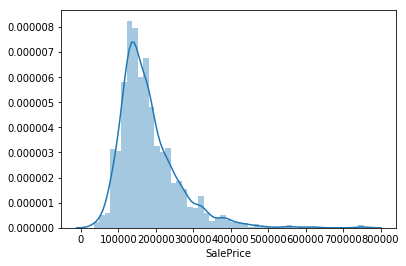

In [6]:
sns.distplot(train['SalePrice']);

Нека видим корелацията между фичърите.

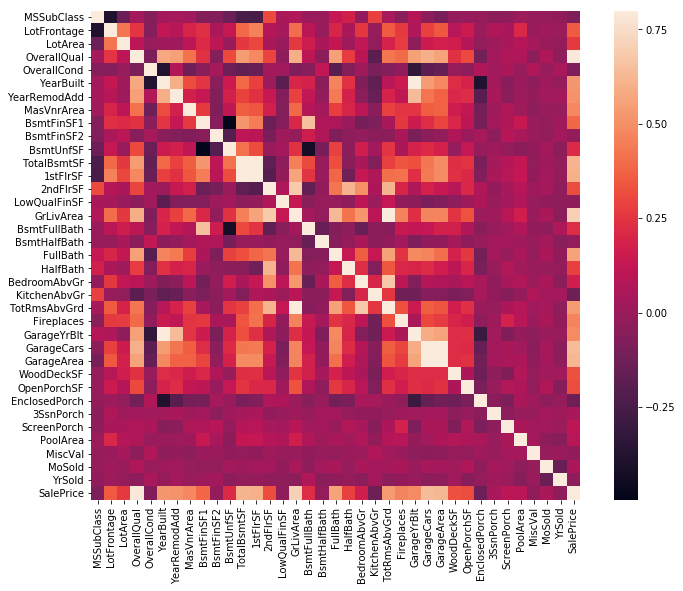

In [7]:
corr = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr, vmax=.8, square=True);

Виждаме, че качеството и големината доста влияят на цената.
Също така големината на гаража и броя на колите.
Големината на мазето, първия етаж, броя на цялостните бани и годината на построяване също доста влияят на цената.

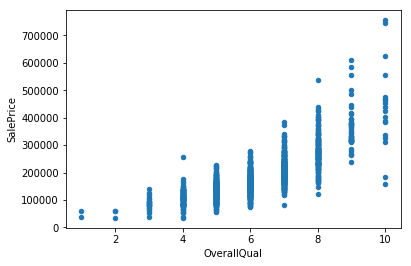

In [8]:
train.plot.scatter(x='OverallQual', y='SalePrice');

Тук виждаме, че при ниско качество, цената също е ниска, но при високо - също има ниски цени.

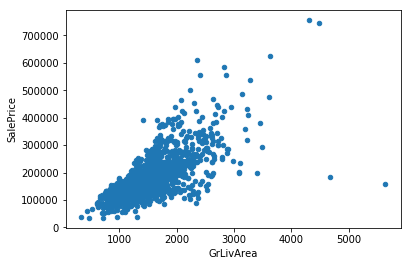

In [9]:
train.plot.scatter(x='GrLivArea', y='SalePrice');

Има малко outliers. По-късно може да ги разгледаме по-подробно.

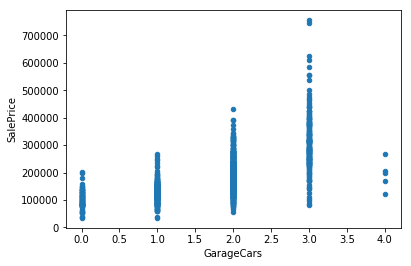

In [10]:
train.plot.scatter(x='GarageCars', y='SalePrice');

Имотите с най-високи цени имат повече гаражи, но има и имоти с ниски цени и повече гаражи.

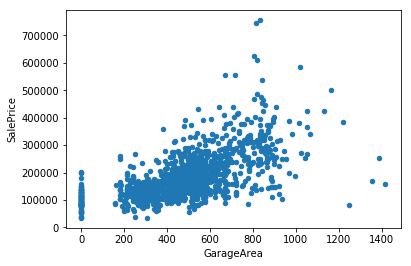

In [11]:
train.plot.scatter(x='GarageArea', y='SalePrice');

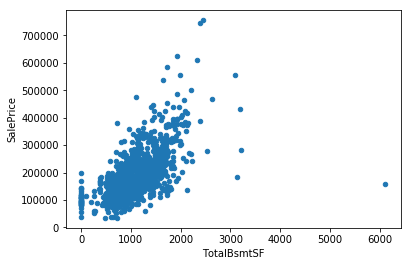

In [12]:
train.plot.scatter(x='TotalBsmtSF', y='SalePrice');

Големина на мазето. Виждаме, че цените нарастват по-рязко и има малко outliers.

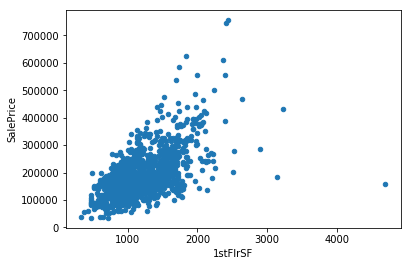

In [13]:
# големина на първи етаж
train.plot.scatter(x='1stFlrSF', y='SalePrice');

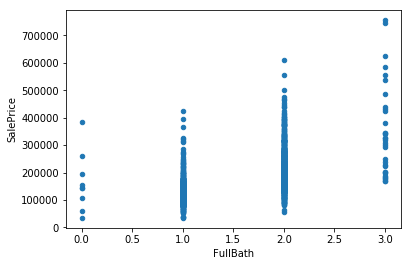

In [14]:
train.plot.scatter(x='FullBath', y='SalePrice');

2-3 бани доста вдигат цената.

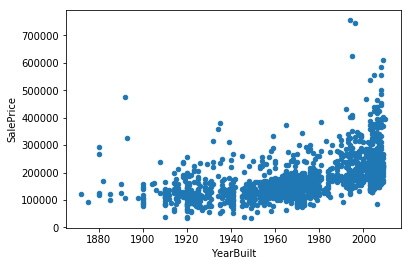

In [15]:
train.plot.scatter(x='YearBuilt', y='SalePrice');

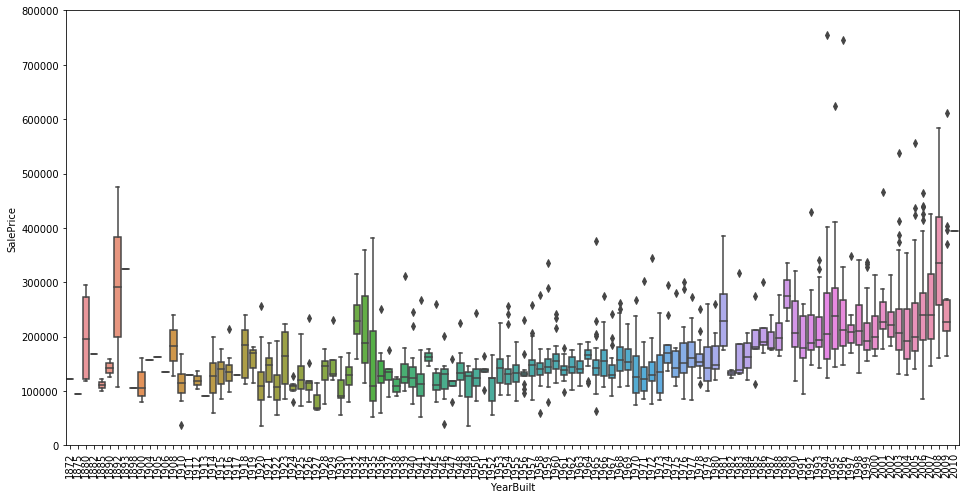

In [16]:
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x='YearBuilt', y='SalePrice', data=train)
fig.axis(ymin=0, ymax=800000)
plt.xticks(rotation=90);

Явно хората плащат повече пари за по-ново строителство.

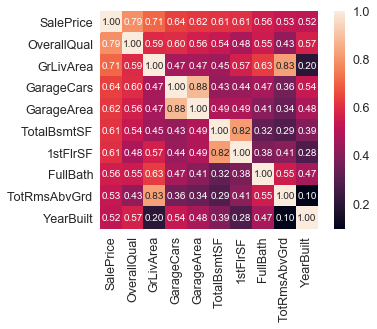

In [17]:
# SalePrice correlation matrix
import numpy as np
k = 10
cols = corr.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 10},
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Тук вече със сигурност виждаме кои фичъри влияят най-много на цената.

'GarageCars' и 'GarageArea' ни носят почти една и същя информация. Тоест можем да запазим само едната от тях, например 'GarageCars', заради по-силната корелация с цената.

Същото забелязваме и при 'TotalBsmtSF' и '1stFlrSF'. Нека запазим само 'TotalBsmtSF'.

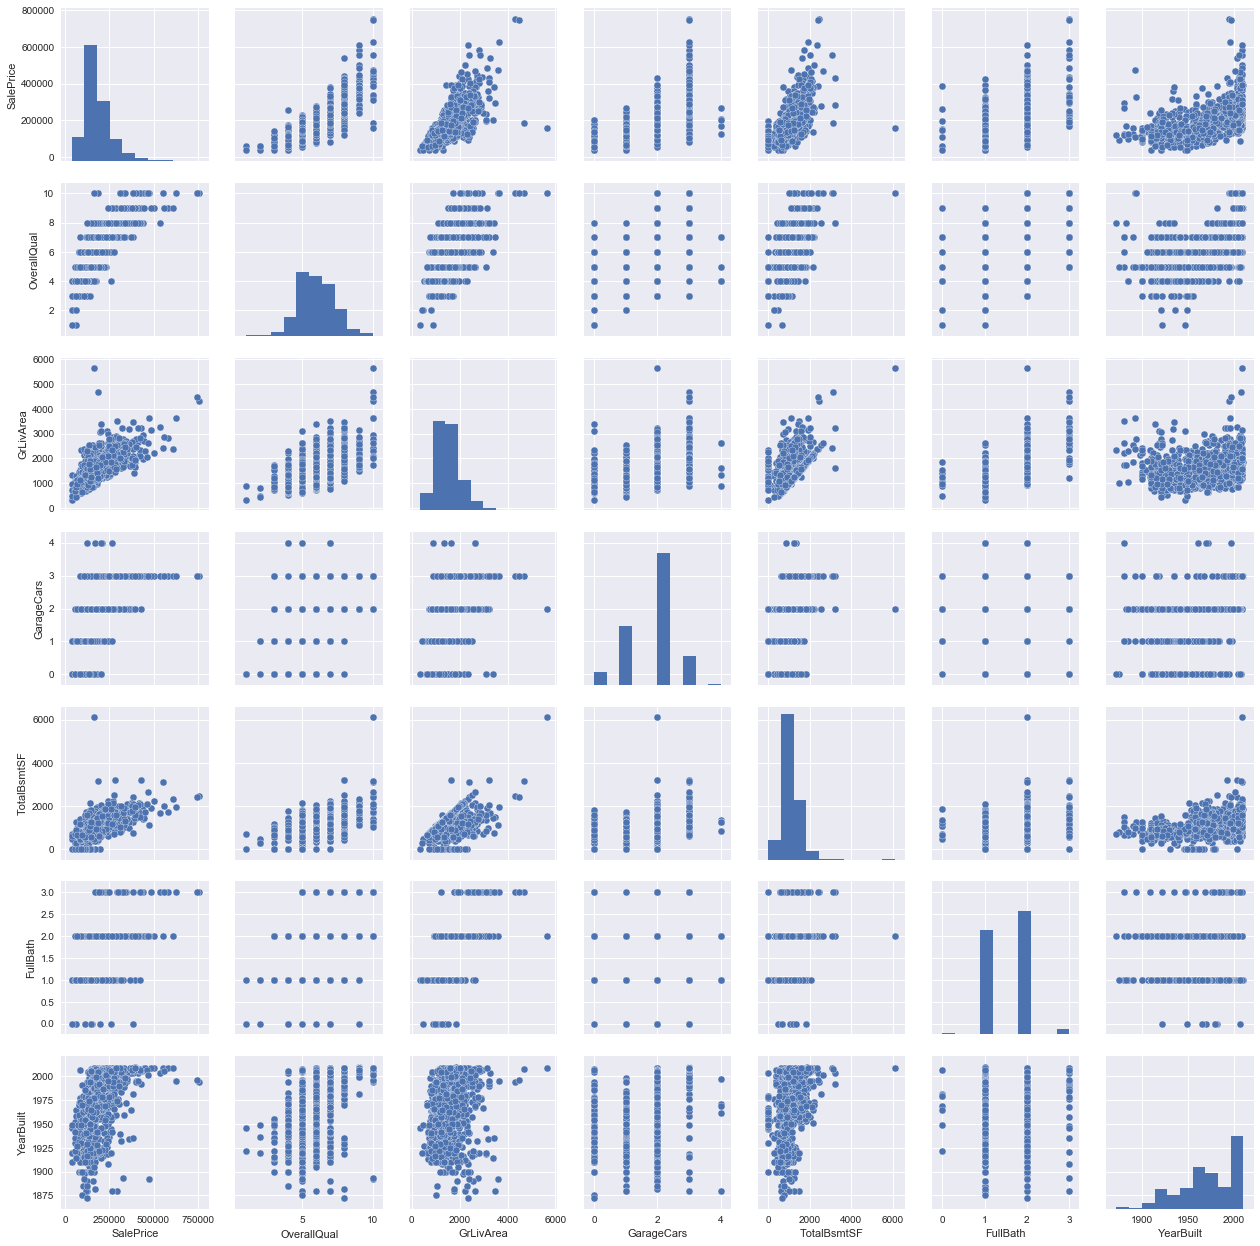

In [18]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[cols], size=2.5)
plt.show()

Тук доста добре виждаме взаимодействието между фичърите.

# Missing data

In [19]:
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageType,81,0.055479
GarageCond,81,0.055479
GarageFinish,81,0.055479
GarageQual,81,0.055479


Можем директно да махмен колоните с повече от 15% липсващи стойности, ако сметнем, че не са особено важни (например 'PoolQC', 'MiscFeature', 'Alley', 'Fence').

Всички фичъри свързани с гараж имат един и същ процент липсващи стойности. Видяхме, че 'GarageCars' е най-важната характеристика свързана с гараж, затова останалите можем да ги изтрием.

Същото можем да направим и с характеристики като 'BsmtX'.

Фичърите 'MasVnrArea' и ''MasVnrType' можем да сметнем като маловажни и просто да ги изтрием. 

При 'Electrical' имаме само една липсваща стойност. Можем да изтрием реда и да запазим колоната. 

In [20]:
train = train.drop(missing_data.query('Total > 1').index, axis=1)
train = train.drop(train.loc[train['Electrical'].isnull()].index)

In [21]:
train.isnull().sum().max()

0

In [22]:
train.shape

(1459, 62)

# Outliers

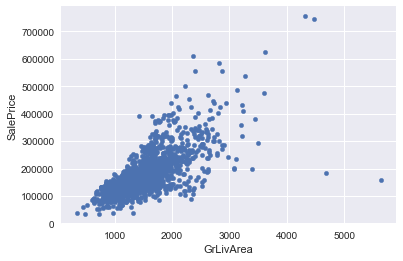

In [23]:
train.plot.scatter(x='GrLivArea', y='SalePrice');

Двете стойности с най-високо 'GrLivArea' доста се отклоняват от останалите точки. Най-вероятно става въпрос за незастроено пространство. Тъй като това не е типичен случай, можем да ги изтрием.

In [24]:
train.sort_values(by='GrLivArea', ascending=False)[:2]

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1299,60,RL,63887,Pave,IR3,Bnk,AllPub,Corner,Gtl,Edwards,...,0,0,0,480,0,1,2008,New,Partial,160000
524,60,RL,40094,Pave,IR1,Bnk,AllPub,Inside,Gtl,Edwards,...,0,0,0,0,0,10,2007,New,Partial,184750


In [25]:
train = train.drop(train.query('Id == 1299').index)
train = train.drop(train.query('Id == 524').index)

Ще се опитаме да нормализираме някои данни.

C:\Users\Viktorya\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


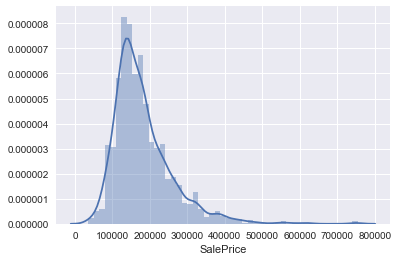

In [26]:
sns.distplot(train['SalePrice']);

Ще пробваме да нормализираме чрез логаритмуване.

C:\Users\Viktorya\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


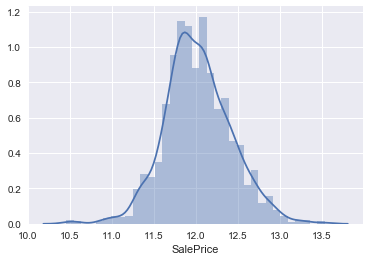

In [27]:
train['SalePrice'] = np.log(train['SalePrice'])
sns.distplot(train['SalePrice']);

C:\Users\Viktorya\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


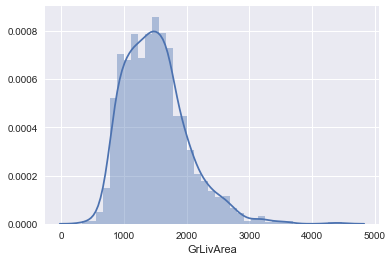

In [28]:
sns.distplot(train['GrLivArea']);

Същото ще направим и за 'GrLivArea'

C:\Users\Viktorya\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


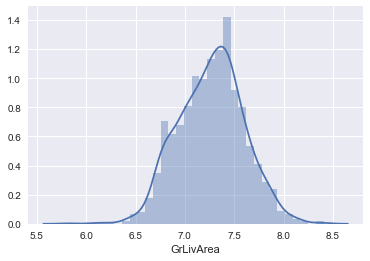

In [29]:
train['GrLivArea'] = pd.np.log(train['GrLivArea'])
sns.distplot(train['GrLivArea']);

C:\Users\Viktorya\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


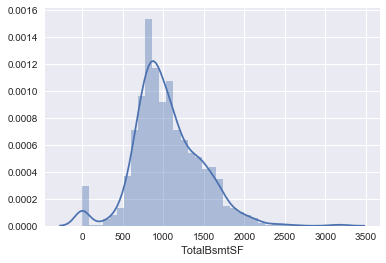

In [30]:
sns.distplot(train['TotalBsmtSF']);

Тук има нулеви стойности. За да логаритмуваме, трябва да променим малко стойностите. Ще добавим нова променлива, която ще има стойност 1, ако има мазе, и 0, ако няма. 

In [31]:
train['HasBsmt'] = [1 if val != 0 else 0 for val in train['TotalBsmtSF']]

Ще трансформираме данните само там, където има 1-ца.

In [32]:
train.loc[train['HasBsmt']==1, 'TotalBsmtSF'] = np.log(train['TotalBsmtSF'])

C:\Users\Viktorya\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


C:\Users\Viktorya\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


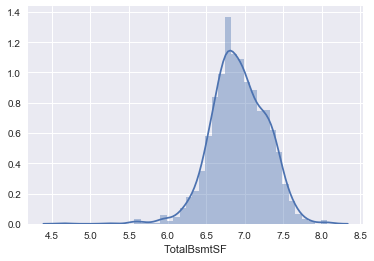

In [33]:
sns.distplot(train[train['TotalBsmtSF']>0]['TotalBsmtSF']);

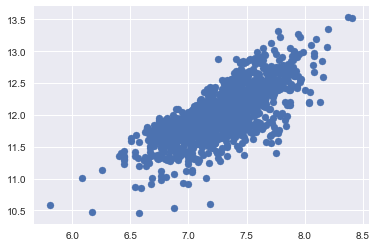

In [34]:
plt.scatter(x=train['GrLivArea'], y=train['SalePrice']);

Сега данните изглеждат по-добре.

# Dummies

In [35]:
train = train.replace({'ExterQual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
                       'ExterCond': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
                       'HeatingQC': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
                       'KitchenQual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}})

За да можем да работим с категорийните колони, ще трябва да ги трансформираме.

Ще създадем dummy-колони за всяка стойност, която ще има 1, ако има тази стойност и 0 в противен случай.

In [36]:
train_set = pd.get_dummies(train)

pd.getdummies() трансформира само категорийните колони, като премахва оригиналната.

In [37]:
train_set.shape

(1457, 207)

In [38]:
from sklearn.model_selection import train_test_split

train_no_sale_price = train_set.drop(columns='SalePrice')
train_sale_price = train_set['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(train_no_sale_price,
                                                    train_sale_price,
                                                    test_size=0.3,
                                                    random_state=4330)

# Linear Regression

In [39]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression().fit(X_train, y_train)

In [40]:
print("Train score: ", regressor.score(X_train, y_train))
print("Test score: ", regressor.score(X_test, y_test))

Train score:  0.9473919851698118
Test score:  0.9048165668870194


# Регуларизация

In [41]:
from sklearn.linear_model import Ridge

alpha = [0.01, 0.1, 1, 10, 90, 100]

for a in alpha:
    all_data_lr = Ridge(alpha=a).fit(X_train, y_train)
    print("alpha: ", a)
    print(all_data_lr.score(X_train, y_train), all_data_lr.score(X_test, y_test))
    print()

alpha:  0.01
0.9473910044246776 0.904943490726222

alpha:  0.1
0.9473375151618896 0.9060280599624375

alpha:  1
0.9462709474230142 0.9124651915457278

alpha:  10
0.938658233053538 0.9194780682837846

alpha:  90
0.9240214200180474 0.9142543665331708

alpha:  100
0.9231391965980468 0.913567279195746



alpha = 90

Train score: 0.9240214200180474

Test score: 0.9142543665331708

Нека отново погледнем корелациите.

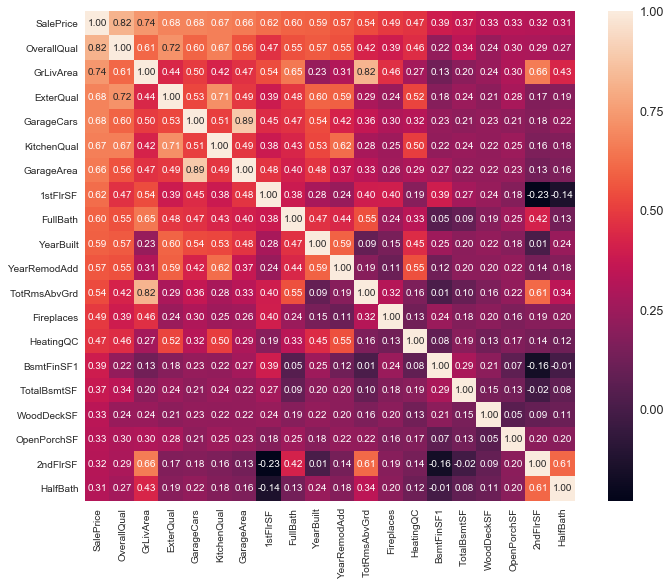

In [42]:
corr2 = train.corr()
k = 20
cols = corr2.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train_set[cols].values.T)
plt.subplots(figsize=(12, 9))
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 10},
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Ще се опитаме да намерим още outliers, които може да премахнем.

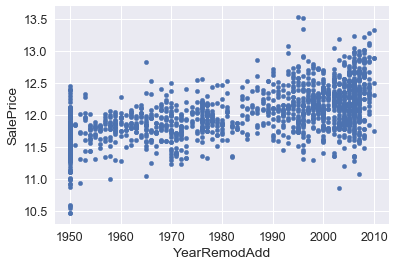

In [43]:
train_set.plot.scatter(x='YearRemodAdd', y='SalePrice');

Тук не намираме нещо полезно.

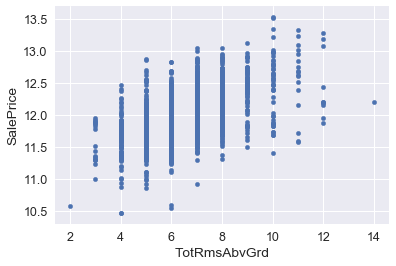

In [44]:
train_set.plot.scatter(x='TotRmsAbvGrd', y='SalePrice');

Тук виждаме, че най-много стаи, не означава най-висока цена. Мисля, че ако премахнем тази най-висока стойност, няма да бъде проблем. 

In [45]:
train_set.sort_values(by='TotRmsAbvGrd', ascending=False)[:1]

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,ExterQual,ExterCond,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
636,190,10896,6,7,1914,1995,2,3,256,0,...,0,0,0,1,1,0,0,0,0,0


In [46]:
train_set = train_set.drop(train_set.query('Id == 636').index)

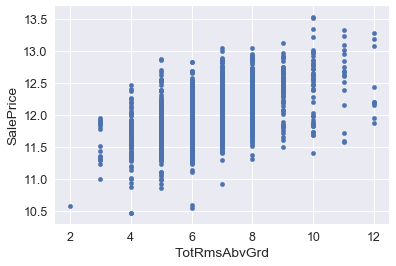

In [47]:
train_set.plot.scatter(x='TotRmsAbvGrd', y='SalePrice');

Да пробваме отново регуларизация.

In [48]:
train_no_sale_price = train_set.drop(columns='SalePrice')
train_sale_price = train_set['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(train_no_sale_price,
                                                    train_sale_price,
                                                    test_size=0.3,
                                                    random_state=4330)

In [49]:
alpha = [0.1, 10, 25, 30, 35, 40, 100]

for a in alpha:
    all_data_lr = Ridge(alpha=a).fit(X_train, y_train)
    print("alpha: ", a)
    print(all_data_lr.score(X_train, y_train), all_data_lr.score(X_test, y_test))
    print()

alpha:  0.1
0.9456924314108425 0.9074489781288416

alpha:  10
0.9362346010420485 0.9285783008347553

alpha:  25
0.9305418769348738 0.9290123309742666

alpha:  30
0.9292908220258447 0.9287397573288497

alpha:  35
0.9282020989826905 0.9284142653500238

alpha:  40
0.9272347635177448 0.9280599322025826

alpha:  100
0.919864729687138 0.9235930976475917



alpha: 35

Train score: 0.9282020989826905

Test score: 0.9284142653500238

Стигнахме до съвсем малко по-добър резултат.

Преди:
Тrain score: 0.9256145142805474, Test score: 0.9122601537609375

Сега:
Train score: 0.9282020989826905, Test score: 0.9284142653500238

In [73]:
# MSSubClass: Identifies the type of dwelling involved in the sale
train_set['MSSubClass'].unique()

array([ 60,  20,  70,  50, 190,  45,  90, 120,  30,  85,  80, 160,  75,
       180,  40], dtype=int64)

In [74]:
temp_train = pd.read_csv('train.csv')
temp_train[['MSSubClass', 'SalePrice']].head(10)

,MSSubClass,SalePrice
0,60,208500
1,20,181500
2,60,223500
3,70,140000
4,60,250000
5,50,143000
6,20,307000
7,60,200000
8,50,129900
9,190,118000


Този фичър е интерпретиран като numeric, но всъщност виждаме, че тип 60 не означава 3 пъти повече от тип 20.

Тези типове са по-скоро кодове, не стойности. Трябва да трансформиране колоната от numeric в categorical.

Едновременно ще направим това и за MoSold и YrSold.

In [75]:
train_set = train_set.replace({'MSSubClass': {20: "SC20", 30: "SC30", 40: "SC40", 45: "SC45",
                                              50: "SC50", 60: "SC60", 70: "SC70", 75: "SC75",
                                              80: "SC80", 85: "SC85", 90: "SC90", 120: "SC120",
                                              160: "SC160", 180: "SC180", 190: "SC190"},
                               'MoSold': {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr",
                                          5: "May", 6: "Jun", 7: "Jul", 8: "Aug",
                                          9: "Sept", 10: "Oct", 11: "Nov", 12: "Dec"}})

Същото можем да направим и с други колони.

In [76]:
train_set["YrSold"] = ["Year" + str(x) for x in train_set['YrSold']]

Някои фичъри могат да бъдат опростени. Например OverallQual и OverallCond.

Нека направим няколко групи: От 1 до 3 - bad, от 4 до 6 - average и от 7 до 10 - good.

In [77]:
train_set['SimpleOverallQual'] = train_set.OverallQual.replace({1: 1, 2: 1, 3: 1,
                                                                4: 2, 5: 2, 6: 2,
                                                                7: 3, 8: 3, 9: 3, 10: 3})
train_set['SimpleOverallCond'] = train_set.OverallCond.replace({1: 1, 2: 1, 3: 1,
                                                                4: 2, 5: 2, 6: 2,
                                                                7: 3, 8: 3, 9: 3, 10: 3})

Отново трябва да направим дъмита за новите категорийни колони.

In [78]:
train_set = pd.get_dummies(train_set)

Добавяме нов фичър, сбор на Total Basement Square Feet, First Floor SF и Second Floor SF.

In [79]:
train_set['TotalSF'] = train_set['TotalBsmtSF'] + train_set['1stFlrSF'] + train_set['2ndFlrSF']

Нека отново да потренираме.

In [80]:
train_no_sale_price = train_set.drop(columns='SalePrice')
train_sale_price = train_set['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(train_no_sale_price,
                                                    train_sale_price,
                                                    test_size=0.3,
                                                    random_state=4330)

In [81]:
alpha = [10, 25, 30, 35, 40, 100]

for a in alpha:
    all_data_lr = Ridge(alpha=a).fit(X_train, y_train)
    print("alpha: ", a)
    print(all_data_lr.score(X_train, y_train), all_data_lr.score(X_test, y_test))
    print()

alpha:  10
0.9378140941930497 0.9290323804686923

alpha:  25
0.9321721923649907 0.9296093341548268

alpha:  30
0.9309097684565046 0.9293242492158263

alpha:  35
0.9298045065814426 0.9289776119319233

alpha:  40
0.9288176865512235 0.9285975099162026

alpha:  100
0.9212022152425509 0.9238138024705622



Успяхме още малко да подобрим резултата.

Преди: Train score: 0.9282020989826905, Test score: 0.9284142653500238

Сега: Train score:  0.9321721923649907,  Test score: 0.9296093341548268